# Code Structure 

### 1. In the main(*args) function, specify the $\textbf{N}:$ no. of atoms, specify the kind of model that is to be evaluated, ex. for dicke case, just set, $\texttt{dicke=True}$, empty lists for counting the states, and storing the orthogonalized basis vectors using Gram Schmidt process. 

### 2. The main function then initializes the tensored pauli operators required for Lindblad calculation for given $\texttt{N}$, using the $\texttt{initialize(N)}$ function.

### 3. The $\texttt{init_state(N)}$ function is used to generate the inital state of the system.

### 4. The $\texttt{e_lis=[]}$ stores the residue at each step, it starts with storing the inital state.

### 5. $\texttt{et}$ stores the orthogonal vectors calculated at each step using the $\texttt{ovec(state)}$ function. Orthogonal vector corresponding to initial state is stored first.

### 6. Depending upon the argument provided for the type of model, (ex. for Dicke case, set $\texttt{dicke=True}$), it evaluates the all the involved states until the norm of residue is $0.0$ using the function $\texttt{liouville_gen()}$

### 7. In the case of $\texttt{general}$, the interaction rates are appropriately treated considering dipolar interactions which depend on the interatomic distance. The atoms are randomly/uniformly separated out in 1D,2D and 3D depending on the input given by the user, and with the flexibility of chosing the polarization of the field. This is achieved by using a set of well-defined functions $\texttt{gamma},\texttt{vec_r},\texttt{int_rate},\texttt{p_arb},\texttt{conig},\texttt{config_rand}$

### 8. For visualization of the atomic orientations, the function $\texttt{draw_atom}$ is used.

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import math
from qutip import *
from piqs import *
from numpy.linalg import multi_dot
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
import itertools
plt.rc('text',usetex=True)

# Initialize lists of pauli operators 

In [2]:
def initialize(N):
    si = qeye(2)
    #sm = np.dot(zero,one.T);
    #sp = np.dot(one,zero.T);
    sm=sigmap() #Qutip uses inverse notation
    sp=sigmam()
    sz_list = []
    sp_list = []
    sm_list = []
    spsm_list = [] 
    
    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)
        
        #Create lists of sp,sm operators for KroneckerProduct(Id2,Id2,...Sp,Id2, Sm) operation
        op_list[n] = sp
        sp_list.append(tensor(op_list))
        
        op_list[n] = Qobj(sm)
        sm_list.append(tensor(op_list))

        #Create a list of spsm operators like KroneckerProduct(Sp.Sm,Id2), yes there is
        op_list[n] = Qobj(np.dot(sp,sm))
        spsm_list.append(tensor(op_list))
        
        
    return sp_list,sm_list,spsm_list

# Define interaction rates
For random interaction rates, the self interaction rate for a particular atom should remain consistent throughout the calculation, also, the rates should be permutational symmetric for symmetric interaction. For instance, $\gamma_{12}=\gamma_{21}$, or in general $\gamma_{ij}=\gamma_{ji}$.
So the total number of distinct  interaction rates required is $N+$$N\choose 2$

In [3]:
# Specify an argument such that it is easy to select between "Dicke","General",etc
def interaction_rates(N,general=False,dicke=False,simp=True):
        
    if simp==True:
        #When all interaction rates are equal
        gamma_i=np.ones(N) 
        gamma_j=np.ones(N)
        #For the Dicke case
    if dicke==True:
        gamma_i=np.asarray(0.5*np.ones(N))
        gamma_j=np.asarray(0.1*np.ones(N))
    #For generalized case. Initially using a set of random rates between (0,1), 
    #but can be done using interatomic distance dependence
    if general==True:
        if N==2:
            gamma_i=0.2*np.ones(N)
            gj=np.random.uniform(0,1,int(math.factorial(N)/(math.factorial(N-2)*math.factorial(2))))
            gamma_j=np.array([gj[0],gj[0]])
        else:    
        #gamma_i=np.random.random(N)
            gamma_i=0.2*np.ones(N)
            gamma_j=np.random.uniform(0,1,int(math.factorial(N)/(math.factorial(N-2)*math.factorial(2))))

    return gamma_i,gamma_j

interaction_rates(2,general=True)

(array([0.2, 0.2]), array([0.0326054, 0.0326054]))

# Initialize the state for evaluation, here $|ee..\rangle \langle ee..|$

In [4]:
def init_state(N):
    op_list = []
    for i in range(N):
        op_list.append(basis(2,1))  #Creating a list of states for excited atoms
    #op_list[1]=basis(2,0)
    ket = tensor(op_list) #Creating a total tensor product state for initally excited atoms
    state = ket2dm(ket) #Creating a density matrix for the initial state
    return state

# Gram Schmidt Orthogonalization Process

# Calculate orthogonal vectors

In [5]:
#Calculate orthogonal vectors
def ovec(state):
    temp=state
    if type(temp)==qutip.qobj.Qobj:
        temp = temp.full()       
    ovec=temp/np.sqrt(np.tensordot(temp,temp))
    return ovec

# Calculate absolute norm of residue


In [6]:
#Calculate absolute norm of residue
def abs_norm(p):
    if type(p)==qutip.qobj.Qobj:
        p = p.full()       
    e=np.ndarray.flatten(p)
    for i in range(len(e)):
        temp = e[i]
        if temp < 0:
            e[i]=-1*temp
    res=np.real(sum(e))
    return res

In [7]:
#Alternate function using inbuilt np.absolute()
def abs_norm(p):
    if type(p)==qutip.qobj.Qobj:
        p = p.full()       
    e=np.ndarray.flatten(p)
    res=np.real(sum(np.absolute(e)))
    return res

# Calculate residue

In [8]:
#Calculating the residue
def fn(e,et,state):
    if type(state)==qutip.qobj.Qobj:
        state = state.full()  
    for i in range(len(et)):
        state = state-np.tensordot(state,et[i])*et[i]
    if abs_norm(state)==0:
        res=0.0
    else:
        ovec = state/np.sqrt(np.tensordot(state,state)) 
        e.append(state)
        et.append(ovec)
        res = abs_norm(state)
    state=(Qobj(state).unit()).full()
    #print('res=',res)
    #print('e=',e)
    #print('et=',et)
    return res,state

# Calculate lindbladian for given state, interaction rates

In [9]:
def liouville_gen(N,state,et,e_lis,gamma_i=[],gamma_j=[],L_list=[],num=[]):
    
    sp_list,sm_list,spsm_list=initialize(N) #initialize all the operator lists
    L_list=[]
    L_list.append(state)

    
    L=[] #storing result of Lindbladian operation
    num_states=[np.count_nonzero(state)] #count states
    #L_list.append(state) #start with the initial state
    L_tot=0
  
    for i in range(N):
        for j in range(N):
            #Solve the Liouville
            if i == j:
                L.append(gamma_i[i]*(Qobj(multi_dot([sm_list[i],state,sp_list[i]])- 0.5*multi_dot([spsm_list[i],state]) - 0.5*multi_dot([state,spsm_list[i]]))))
            else:
                L.append(gamma_j[i]*(Qobj(multi_dot([sm_list[j],state,sp_list[i]])-0.5*multi_dot([sp_list[i],sm_list[j],state]) - 0.5*multi_dot([state,sp_list[i],sm_list[j]]))))

    size=len(L)

    for n in range(size):
        L_tot=L_tot+L[n] #Summing all the terms in Lindbladian
    
    L_list.append(L_tot)
    num_states.append(np.count_nonzero(L_tot))
    size2=len(L_list)
    
    for m in range(0,size2):
        num_states.append(np.count_nonzero(L_list[m]))
        
    num.append(num_states[1])
    #np.real(np.asarray(L_list).full())

    res,state = fn(e_lis,et,L_tot)
    #np.set_printoptions(precision=3)
    
    
    #residue can be used directly for next Lindbladian operation (orthogonal part) and normalize it!
    #Also keep max.inter. rate = 1
    #self-interactions (check literature)
    #setting precision: comparing norms of resulting state and residue n_state/n_norm~1e-9
    n_state = abs_norm(state)
    precision=res/abs_norm(state)
    #(L_tot.full()).clear()
    if precision<1e-6:
        res = np.round(res,5)

    if res!=0.0:
        state = state
        #evec = ovec(state)
        #et_lis.append(evec)
        #et.append(evec)
    #    if simp==True:
    
        liouville_gen(N,state,et,e_lis,gamma_i,gamma_j,num)
     #   if dicke==True:
        #    liouville_gen(N,state,et,e_lis,num,dicke=True)
      #  if general==True:
       #     liouville_gen(N,state,et,e_lis,num,general=True)
         
    else:
        #print("total no. of states =", np.count_nonzero(L_tot))
        print("All states found!")
    
    print("state=",L_tot)
    print("res=",res)
    print("number of states involved = ",len(num)+1)
    print("states=",num)
    print("gamma=",gamma_i)
    #print('inner =',inner) 
    #print('et=',et)
    num.clear()
    return 





# All pieces together

In [10]:
def main(N,num=[],et=[],dicke=False,general=False,simp=False):
    #num.clear()
    et.clear()
    initialize(N)
    state=init_state(N)
    e_lis=[] 
    e_lis.append(state)
    evec = ovec(state)
    #et_lis.append(evec)
    et.append(evec)

    if simp==True:
        gamma_i,gamma_j = interaction_rates(N)  #define interatcion rates depending on the model needed        
        liouville_gen(N,state,et,e_lis,gamma_i=[],gamma_j=[],L_list=[],num=[],simp=True)
        
    if dicke==True:
        gamma_i,gamma_j = interaction_rates(N,dicke=True)  #define interatcion rates depending on the model needed        
        liouville_gen(N,state,et,e_lis,gamma_i=[],gamma_j=[],L_list=[],num=[],dicke=True)

    if general==True:
        gamma_i,gamma_j = interaction_rates(N,general=True)
        #gamma_i= gamma(N,5e-9,3e9,'p_perpendi','line_x') #define interatcion rates depending on the model needed        
        liouville_gen(N,state,et,e_lis,gamma_i,gamma_j,L_list=[],num=[])

# Execute

In [11]:
main(2,num=[],general=True)

All states found!
state= Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.        0.        0.        0.       ]
 [0.        0.        0.0221598 0.       ]
 [0.        0.0221598 0.        0.       ]
 [0.        0.        0.        0.       ]]
res= 0.0
number of states involved =  4
states= [5, 2, 2]
gamma= [0.2 0.2]
state= Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.         0.         0.         0.        ]
 [0.         0.         0.00143137 0.        ]
 [0.         0.00143137 0.         0.        ]
 [0.         0.         0.         0.        ]]
res= 0.0027586472386660356
number of states involved =  1
states= []
gamma= [0.2 0.2]
state= Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.40274015  0.          0.          0.        ]
 [ 0.         -0.20137007 -0.2         0.        ]
 [ 0.         -0.2        -0.20137007  0.        ]
 [ 0.          

# Results

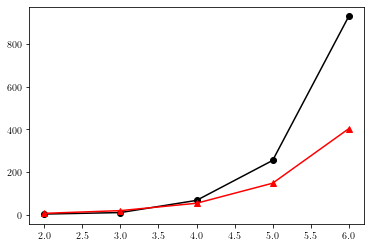

In [12]:
#Simple case
n_atoms = [2,3,4,5,6,7]
states = [3,4,5,6,7,8]
#(N+1) states


#Dicke Case
n_atoms = [2,3,4,5,6,7]
states = [3,6,9,12,15,20]
#polynomial states

#Symmetric Interaction Rates Improvised Case
n_atoms = [2,3,4,5,6]
states =[4,11,68,255,929]#fluctations seen for N=5 (250-255 states)

plt.plot(n_atoms,states,'ko-')
plt.plot(n_atoms,np.exp(n_atoms),'r^-')

# Comparison with the PIQS Library

For benchmarking the results from the Dicke Model and Shammah's paper


In [13]:
# Finding size of involved Hilbert space for 2 TLS
N=3
system = Dicke(N=N)
[jx, jy, jz] = jspin(N)
id2=np.identity(N)
jp,jm = jspin(N,"+"), jspin(N,"-")
jpjm = jp*jm
jmjp = jm*jp
#jp1 = tensor(jp, identity(2))
#jm1 = tensor(jm, identity(2))
#jp2 = tensor(identity(2),jp)
#jm2 = tensor(identity(2),jm)

#jp1jm2 = tensor(jp*jm,qeye(N))
#jp2jm1 = tensor(qeye(N),jm*jp)
#print(jp1jm2,jp2jm1)
#jp1jm2 = tensor(sigmap(), sigmam())
#jp2jm1 = tensor(sigmam(), sigmap())
sprepost(sigmam(),sigmap())
    
H = jpjm+jmjp
#print(H)


delta = 0.10
gamma = 10
system.hamiltonian = H
system.emission = delta
system.dephasing = gamma
D_ttls = system.liouvillian()

# initial state
excited_rho = excited(N)

rho_0 = dicke(N,N/2,N/2)

#Dicke Basis
dicke_basis = np.real(block_matrix(N))
#Dicke states
#rho0 = dicke(N, N/2, N/2)

#rho0=excited_rho
#rho5 = np.real(excited_state.full())
#nt = 1001
#gCE, gD, gE = 1, 1, 0
#td0 = np.log(N)/(N*gCE)
#tmax = 10 * td0

#t = np.linspace(0,100, nt)

#result = mesolve(D_ttls, rho0, t, [], e_ops = [],options = Options(store_states=True))
#rhot = result.states

steady_tls = steadystate(D_ttls)
jz_ss = expect(jz, steady_tls)
jpjm_ss = expect(jp*jm, steady_tls)

#rho0_tls = dicke(N, N/2, -N/2)
t = np.linspace(0, 20, 1000)
result = mesolve(D_ttls, rho_0, t, [], e_ops = [])

rhot_tls = result.states
#jzt = result.expect[0]

system.dephasing = 1

print(excited_rho)
print(rhot_tls[-1])
result2=mesolve(D_ttls, rhot_tls[-1], t, [], e_ops = [])

rhot_tls2 = result2.states
print(rhot_tls2[-1])


result3=mesolve(D_ttls, rhot_tls2[-1], t, [])
rhot_tls3 = result3.states
print(rhot_tls3[-1])
Qobj=rhot_tls3[-1].full()
len(Qobj)


#for i in range(100)

Quantum object: dims = [[6], [6]], shape = (6, 6), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Quantum object: dims = [[6], [6]], shape = (6, 6), type = oper, isherm = True
Qobj data =
[[0.00247875 0.         0.         0.         0.         0.        ]
 [0.         0.01583694 0.         0.         0.         0.        ]
 [0.         0.         0.10118274 0.         0.         0.        ]
 [0.         0.         0.         0.64646244 0.         0.        ]
 [0.         0.         0.         0.         0.03167368 0.        ]
 [0.         0.         0.         0.         0.         0.20236563]]
Quantum object: dims = [[6], [6]], shape = (6, 6), type = oper, isherm = True
Qobj data =
[[6.14223388e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.29300300e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00

6

# Finding analytic expression

[  16.   36.   81.  144.  256.  400.  625.  900. 1296. 1764. 2401. 3136.
 4096.]


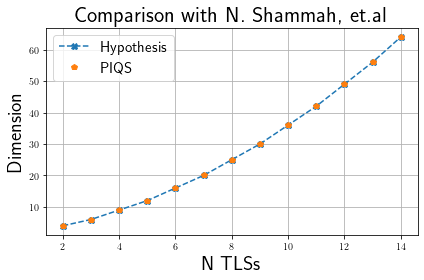

In [14]:
dim=np.array([16,36,81,144,256,400,625,900,1296,1764,2401,3136,4096])
N=np.array([2,3,4,5,6,7,8,9,10,11,12,13,14])
#fit=np.polyfit(N,n**2,2)
#yi=np.polyval(fit,N)
#plt.plot(N,yi,'g-')
fig, ax = plt.subplots()

plt.plot(N,dim**0.5,'X--')
plt.grid()
#print(fit,yi)
f=(2*(N+1)**2+4*(N+1)+1-(-1)**(N+1))/8
print(f*f)
plt.plot(N,f,'p')
d='Hypothesis';t='PIQS'

plt.legend([d,t])
plt.legend([d,t],loc=2, prop={'size': 15})
plt.rc('xtick',labelsize=10)
plt.xlabel('N TLSs',fontsize=20)
plt.ylabel('Dimension',fontsize=20)
plt.title('Comparison with N. Shammah, et.al',fontsize=22)
plt.tight_layout()
#fig.set_size_inches(8, 8, forward=False)
plt.savefig('Benchmarking_PIQS.jpeg',dpi=900)

$f=\frac{1}{8}(2(N+1)^2+4(N+1)+1-(-1)^{(N+1)})$

# Calculating interaction rates as per Jen's article 
$\frac{3\Gamma}{2}\left\{ [1-(\hat{\textbf{p}}\cdot\hat{r}_{ij})^2]\frac{\sin{\xi}}{\xi} + [1-3(\hat{\textbf{p}}\cdot\hat{r}_{ij})^2]\left(\frac{\cos{\xi}}{\xi^2} -\frac{\sin{\xi}}{\xi^3}\right)\right\}$,

$\Gamma=\frac{d^2 \omega_e^3}{3\pi \hbar \epsilon_0 c^3}$

$k_L = \frac{\omega_e}{c}$

$\xi = k_L|\textbf{r}_{i}-\textbf{r}_{j}|$

$\hat{\textbf{p}}$, excitation field polarization

For field polarizations, consider:
1. Parallel polarization
$\hat{\textbf{p}}=\hat{i}+\hat{j}+\hat{k}$
2. Perpendicular polarization
$\hat{\textbf{p}}=0\hat{i}+0\hat{j}+0\hat{k}$
3. Arbitrary polarization

$\hat{\textbf{p}}=\hat{i}$, $\hat{\textbf{p}}=\hat{j}+\hat{k}$


$\hat{\textbf{p}}=\hat{j}$, $\hat{\textbf{p}}=\hat{i}+\hat{k}$

$\hat{\textbf{p}}=\hat{k}$, $\hat{\textbf{p}}=\hat{i}+\hat{j}$

## For different configurations:
1. Line configuration:
a. Uniform separation
b. Randomly separated in 1D

2. Square (2D) configuration:
a. Uniform Separation
b. Random Separation

3. 3D Space
a. Uniform Separation
b. Random Separation

## Calculating arbitrary polarization vector

In [15]:
#Function for arbitrary polarization
def p_arb():
    val=[]
    for n in range(3):
        val.append(float(input()))
    vec=np.array(val)
    p=vec/np.dot(vec,vec)
    return p


## Calculate atomic position vectors

In [16]:
#Defining the atomic position vectors

def vec_r(ri,rj):
    ri=np.array(ri)
    rj=np.array(rj)
    #ri,rj are [rx,ry,rz] array with each element as x,y,z coordinates
    #for i in range(len(ri)):
    if np.array_equal(ri,rj)==True:
        r_ij = (ri-rj)
        mag = 0
        rij = r_ij
        #print('Same position')
    else:
        r_ij = (ri-rj)
        #mag1 = np.abs(np.sqrt(r_ij[0]*r_ij[0]+r_ij[1]*r_ij[1]+r_ij[2]*r_ij[2]))
        mag = np.sqrt(np.dot(r_ij,r_ij))
        rij=r_ij/mag
    return rij,mag
vec_r([0,0,0],[7,0,0])

(array([-1.,  0.,  0.]), 7.0)

## Arranging the atoms in desired configuration and dimension
 Unit separation
 
 Random distribution in given range

In [17]:
# Unit separation
def config(N,line_x=False,square=False,cube=False):
    r=[]
    r2 =[]
    if line_x==True:
        for i in range(N):
            r.append([i,0,0])
        r=r    
    elif square==True:
        for i in range(N):
            for j in range(N):
                r2.append([i,j,0])
        v=random.sample(r2,k=N)
        r.append(v)
        r=r[0]
    elif cube==True:
        for i in range(N):
            for j in range(N):
                for k in range(N):
                    r2.append([i,j,k])
        v=random.sample(r2,k=N)
        r.append(v)
        r=r[0]
    return r
config(6,cube=True)    

[[0, 5, 1], [3, 3, 5], [4, 5, 3], [1, 0, 4], [3, 1, 3], [5, 2, 0]]

In [18]:
# Random separation
#Use of random.choices()
#we'll use this to choose N atomic positions from generated 2d,3d array, where N is the number of atoms
#q=[1,2,3,3,3]
#random.choices(q, k=2)#This choses the same elements too
#for unique selection, random.sample() can be used
def config_rand(N,line_x=False,square=False,cube=False):
    r=[]
    r2 =[]
    if line_x==True:
        for i in range(N):
            x=np.random.uniform(1,100,1)
            r.append([x[0],0,0])
        r=r    
    elif square==True:
        for i in range(N):
            for j in range(N):
                x=np.random.uniform(1,100,2)
                r2.append([x[0],x[1],0])
        v=random.sample(r2,k=N)
        r.append(v)
        r=r[0]
    elif cube==True:
        for i in range(N):
            for j in range(N):
                for k in range(N):
                    x=np.random.uniform(1,100,3)
                    r2.append([x[0],x[1],x[2]])
        v=random.sample(r2,k=N)
        r.append(v)
        r=r[0]
    return r
config_rand(6,cube=True)    

[[71.08037311222691, 28.654912631361963, 98.14515860400248],
 [12.617144026400261, 42.9638412603971, 39.66632730975336],
 [10.345276056733486, 78.9840144496223, 40.16176509173035],
 [33.38793481829216, 61.53953357305529, 48.505101314133505],
 [10.747372024187602, 67.28683461754314, 5.435405436957939],
 [14.207845222555358, 76.98195872813605, 72.60498142064573]]

## Calculating ${\gamma_{ij}}$
### $\gamma_{ij}=\frac{3\Gamma}{2}\left\{ [1-(\hat{\textbf{p}}\cdot\hat{r}_{ij})^2]\frac{\sin{\xi}}{\xi} + [1-3(\hat{\textbf{p}}\cdot\hat{r}_{ij})^2]\left(\frac{\cos{\xi}}{\xi^2} -\frac{\sin{\xi}}{\xi^3}\right)\right\}$

In [19]:
def int_rate(N,gamma,r_ij,xi,p):
    rate=[]
    for i in range(len(xi)):
            rate.append((3*gamma/2)*((1-(np.dot(p,r_ij[i]))**2)*(np.sin(xi[i])/xi[i]) + (1-3*(np.dot(p,r_ij[i]))**2)*((np.cos(xi[i])/xi[i]**2)-(np.sin(xi[i])/xi[i]**3))))
    return rate
#r_ij,xi,p=gamma(5,5e-9,3e9,'p_parallel','cube')
#int_rate(5,1.5,r_ij,xi,p)

In [20]:
def gamma(N,polarization,configuration,dist):
    if polarization=='p_arbitrary':
        p = p_arb()
    if polarization=='p_perpendi':
        p = np.zeros(3)
    if polarization=='p_parallel':
        p = np.ones(3)         
    c=3e8
    omega_e=5e14
    lamda=c/omega_e
    #hbar=6.664e-34/2*np.pi
    hbar=1
    epsilon_o=8.8541878128e-12
    #gamma = ((d**2)*omega_e**3)/(3*np.pi*hbar*epsilon_o*(c**3))
    gamma=1
    k_l = 1 #Since, gamma ~ (omega_e/c)**3, or gamma = A*(omega_e/c)**3, assume A=1
    k=2*np.pi/lamda
    r_ij=[]
    rij=[]
    xi=[]
    rate=[]
    if dist=='uniform':
        if configuration=='line_x':
            r=config(N,line_x=True) 
        if configuration=='square':
            r=config(N,square=True) 
        if configuration=='cube':
            r=config(N,cube=True)
    
    if dist=='random':
        if configuration=='line_x':
            r=config_rand(N,line_x=True) 
        if configuration=='square':
            r=config_rand(N,square=True) 
        if configuration=='cube':
            r=config_rand(N,cube=True)
            
    for i in range(len(r)):
        for j in range(len(r)):
            
            #vec_r(r[i],r[j])
            #if i==j:
                #r_ij.append(vec_r(r[i],r[j])[0])
                #rij.append(vec_r(r[i],r[j])[1])   
                #xi.append(1)
               # print(i,i)
            #    rate.append(3*gamma/2)
            #if i!=j:
              #  print(i,j)
                r_ij.append(vec_r(r[i],r[j])[0])
                rij.append(vec_r(r[i],r[j])[1])   
                xi.append(k_l*vec_r(r[i],r[j])[1])
                
               # int_rate=(3*gamma/2)*((1-(np.dot(p,r_ij[i]))**2)*(np.sin(xi[i])/xi[i]) + (1-3*(np.dot(p,r_ij[i]))**2)*((np.cos(xi[i])/xi[i]**2)-(np.sin(xi[i])/xi[i]**3)))
                #rate.append(int_rate)
               # print(int_rate)

    rate = int_rate(5,1.5,r_ij,xi,p)
    df=pd.DataFrame(rate)
    rates=df.replace(np.nan, 0.5)
    for i in range(len(rate)):
        if rate[i]==np.nan:
            rate[i]=gamma/2
    rate_f = rates.to_numpy()
   # for i in range(len(rate)):
   #     for j in range(len(rate)):
   #         if i==j:
   #             rate[j]=3*gamma/2
    f_rate=[]
    for r in range(len(rate_f)):
     #   for s in range(len(rate_f)):
      #      if r==s:
                f_rate.append(rate_f[r][0])
    f_rate=np.array(f_rate)
    #draw_atom(N,configuration)
    return f_rate

## Visualization of the atomic positions

In [21]:
def draw_atom(N,dist,confign,pts=None):
    if dist=='uniform':
        if confign=='line_x':
            pts=config(N,line_x=True)
        if confign=='square':
            pts=config(N,square=True)
        if confign=='cube':
            pts=config(N,cube=True)
    
    if dist=='random':
        if confign=='line_x':
            pts=config_rand(N,line_x=True)
        if confign=='square':
            pts=config_rand(N,square=True)
        if confign=='cube':
            pts=config_rand(N,cube=True)        

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # plotting the points
    pts = pts
    for p in pts:
        ax.scatter(p[0], p[1], p[2], zdir='z', c='r')
        maxn=max(p[0],p[1],p[2])
    # plotting lines for each point pair
    for a, b in itertools.product(pts, pts):
        x = np.linspace(a[0], b[0], 100)
        y = np.linspace(a[1], b[1], 100)
        z = np.linspace(a[2], b[2], 100)
        #ax.set_xlabel('Dist')

        ax.plot(x, y, z)

    #ax.legend()
    if dist=='random':
        ax.set_xlim3d(0, maxn)
        ax.set_ylim3d(0, maxn)
        ax.set_zlim3d(0, maxn)
        ax.set_xlabel('Dist')

    else:
        ax.set_xlim3d(0, N)
        ax.set_ylim3d(0, N)
        ax.set_zlim3d(0, N)
    ax.set_xlabel('$(a/\lambda_0)_x$',fontsize=20)
    ax.set_ylabel('$(a/\lambda_0)_y$',fontsize=20)
    ax.set_zlabel('$(a/\lambda_0)_z$',fontsize=20)

    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick',labelsize=20)    
    plt.title(r'Atoms in 3D',fontsize=20)
    plt.savefig('Atoms_3D_Random.jpeg',dpi=900)
    plt.show()
    return 


<ipython-input-21-3bb17b5cc1a3>:19: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


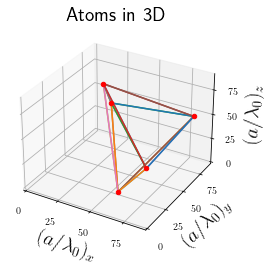

In [22]:
draw_atom(5,'random','cube')


## Calculating the states

In [23]:
def liouville_gen(N,state,et,e_lis,gamma_i=[],gamma_j=[],L_list=[],num=[]):
    
    sp_list,sm_list,spsm_list=initialize(N) #initialize all the operator lists
    L_list=[]
    L_list.append(state)

    
    L=[] #storing result of Lindbladian operation
    num_states=[np.count_nonzero(state)] #count states
    #L_list.append(state) #start with the initial state
    L_tot=0
  
    for i in range(N):
        for j in range(N):
            #Solve the Liouville
            if i == j:
                L.append(gamma_i[i]*(Qobj(multi_dot([sm_list[i],state,sp_list[i]])- 0.5*multi_dot([spsm_list[i],state]) - 0.5*multi_dot([state,spsm_list[i]]))))
            else:
                L.append(gamma_j[i]*(Qobj(multi_dot([sm_list[j],state,sp_list[i]])-0.5*multi_dot([sp_list[i],sm_list[j],state]) - 0.5*multi_dot([state,sp_list[i],sm_list[j]]))))
           
    size=len(L)

    for n in range(size):
        L_tot=L_tot+L[n] #Summing all the terms in Lindbladian
    
    L_list.append(L_tot)
    num_states.append(np.count_nonzero(L_tot))
    size2=len(L_list)
    
    for m in range(0,size2):
        num_states.append(np.count_nonzero(L_list[m]))
        
    num.append(num_states[1])
    #np.real(np.asarray(L_list).full())

    res,state = fn(e_lis,et,L_tot)
    #np.set_printoptions(precision=3)
    
    
    #residue can be used directly for next Lindbladian operation (orthogonal part) and normalize it!
    #Also keep max.inter. rate = 1
    #self-interactions (check literature)
    #setting precision: comparing norms of resulting state and residue n_state/n_norm~1e-9
    n_state = abs_norm(state)
    precision=res/abs_norm(state)
    #(L_tot.full()).clear()
    if precision<1e-6:
        res = np.round(res,5)

    if res!=0.0:
        state = state

    
        liouville_gen(N,state,et,e_lis,gamma_i,gamma_j,num)
   
    else:
        #print("total no. of states =", np.count_nonzero(L_tot))
        print("All states found!")
    
    print("state=",L_tot)
    print("res=",res)
    print("number of states involved = ",len(num)+1)
    print("states=",num)
    print("gamma=",gamma_i)
    #print('et=',et)
    num.clear()
    return 





## All pieces together

In [24]:
def main(N,num=[],et=[],dicke=False,general=False,simp=False):
   # num.clear()
    et.clear()
    initialize(N)
    state=init_state(N)
    e_lis=[] 
    e_lis.append(state)
    evec = ovec(state)
    #et_lis.append(evec)
    et.append(evec)

    if simp==True:
        gamma_i,gamma_j = interaction_rates(N)  #define interatcion rates depending on the model needed        
        liouville_gen(N,state,et,e_lis,gamma_i=[],gamma_j=[],L_list=[],num=[],simp=True)
        
    if dicke==True:
        gamma_i,gamma_j = interaction_rates(N,dicke=True)  #define interatcion rates depending on the model needed        
        liouville_gen(N,state,et,e_lis,gamma_i=[],gamma_j=[],L_list=[],num=[],dicke=True)
        
    if general==True:
        gamma_i= gamma(N,'p_perpendi','line_x','random') #define interatcion rates depending on the model needed        
        liouville_gen(N,state,et,e_lis,gamma_i,gamma_i,L_list=[],num=[])

## Execute

In [25]:
from qutip import *
main(4,general=True)

<ipython-input-19-c1afc09f738c>:4: RuntimeWarning: invalid value encountered in double_scalars
  rate.append((3*gamma/2)*((1-(np.dot(p,r_ij[i]))**2)*(np.sin(xi[i])/xi[i]) + (1-3*(np.dot(p,r_ij[i]))**2)*((np.cos(xi[i])/xi[i]**2)-(np.sin(xi[i])/xi[i]**3))))
<ipython-input-19-c1afc09f738c>:4: RuntimeWarning: divide by zero encountered in double_scalars
  rate.append((3*gamma/2)*((1-(np.dot(p,r_ij[i]))**2)*(np.sin(xi[i])/xi[i]) + (1-3*(np.dot(p,r_ij[i]))**2)*((np.cos(xi[i])/xi[i]**2)-(np.sin(xi[i])/xi[i]**3))))


All states found!
state= Quantum object: dims = [[16], [16]], shape = (16, 16), type = oper, isherm = False
Qobj data =
[[ 3.78678994e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  4.43635745e-02  4.15872365e-03  0.00000000e+00
  -2.74851253e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   7.25491019e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.46125735e-01 -1.10480011e-01  0.00000000e+00
  -3.60655680e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.30361117e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -9.05583728e-02
   0.00000000e+00 -

## Results

In [26]:
#Parallel polarization
#1D Uniform Separation
n=[2,3,4,5,6]
states=[4,10,59,220,808]

#2D Uniform Separation
n=[2,3,4,5,6]
states=[4,10,59,170-220,805-820]

#3D Uniform Separation
n=[2,3,4,5,6]
states=[4,10,59,170-220,805-820]

#1D Random Separation
n=[2,3,4,5,6]
states=[4,10,28-55,174-220,808-820]

#2D Random Separation
n=[2,3,4,5,6]
states=[4,10,59,170-220,805-820]

#3D Random Separation
n=[2,3,4,5,6]
states=[4,10,28-55,174-220,808-820]


#Perpendicular Polarization, it's evident that for parallel polarization all of the relevant states are captured.




# Comparison with 
$4^N, N^4$,  $\frac{1}{6}(N+1)(N+2)(N+3)$, $\frac{1}{8}(2(N+1)^2+4(N+1)+1-(-1)^{(N+1)})$

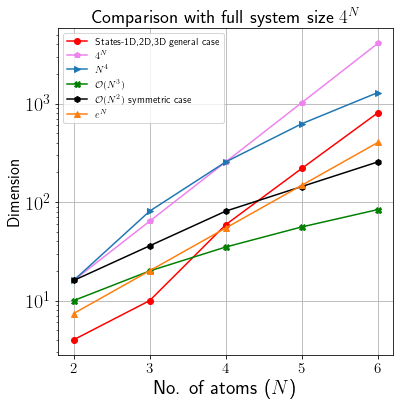

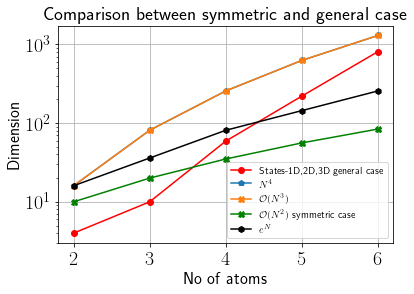

In [47]:
dim_poly=[]
for n in range(2,7):
    dim_poly.append((n+1)*(n+2)*(n+3)/6)
dim_quartic=[]
for n in range(2,7):
    dim_quartic.append(4**n)
dim_quart=[]    
for n in range(2,7):
    dim_quart.append(n**4)

n=np.array([2,3,4,5,6])
f=(2*(n+1)**2+4*(n+1)+1-(-1)**(n+1))/8
n=[2,3,4,5,6]
states=np.array([4,10,59,220,808])
#states=np.array([4,7,10,13,16,19])
#states_2d=np.array([6,10,14,18,22,26])

fig, ax = plt.subplots()

ax.plot(n,states,'ro-')

ax.plot(n,dim_quartic,'p-',color='violet')
ax.plot(n,dim_quart,'>-')

#plt.plot(n,states_2d*states_2d,'p-')
ax.plot(n,dim_poly,'gX-')
ax.plot(n,f*f,'kh-')
ax.plot(n,np.exp(n),'^-')

l='States-1D,2D,3D general case'
#s = '2D and 3D'
t='$4^N$'
q='$N^4$'
p = '$\mathcal{O}(N^3)$'
a = '$\mathcal{O}(N^2)$ symmetric case'
e='$e^N$'

ax.legend([l,t,q,p,a,e])
plt.rc('xtick', labelsize=20) 
plt.rc('ytick',labelsize=20)
plt.xlabel('No. of atoms ($N$)',fontsize=20)
plt.ylabel('Dimension',fontsize=17)
ax.grid()
plt.title('Comparison with full system size $4^N$',fontsize=19)
#axins = zoomed_inset_axes(ax, 1, loc=1) # zoom = 6
#axins.plot(n, states)
#axins.set_xlim(5,6) # Limit the region for zoom
#axins.set_ylim(0, 400)

#plt.xticks(visible=False)  # Not present ticks
#plt.yticks(visible=False)
#
## draw a bbox of the region of the inset axes in the parent axes and
## connecting lines between the bbox and the inset axes area
#mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
ax.set_yscale('log')
#ax.set_xscale('log')

fig.set_size_inches(6, 6, forward=False)
plt.savefig('Results_final_ylog.jpeg',dpi=800)
plt.draw()


#Without 4**N
dim_poly=[]
for n in range(2,7):
    dim_poly.append((n+1)*(n+2)*(n+3)/6)
dim_quartic=[]
for n in range(2,7):
    dim_quartic.append(n**4)


n=np.array([2,3,4,5,6])
f=(2*(n+1)**2+4*(n+1)+1-(-1)**(n+1))/8
n=[2,3,4,5,6]
states=np.array([4,10,59,220,808])
#states=np.array([4,7,10,13,16,19])
#states_2d=np.array([6,10,14,18,22,26])

fig, ax = plt.subplots()

ax.plot(n,states,'ro-')

ax.plot(n,dim_quartic,'p-')
#ax.plot(n,dim_quart,'*--')
ax.plot(n,dim_quart,'X-')

#plt.plot(n,states_2d*states_2d,'p-')
ax.plot(n,dim_poly,'gX-')
ax.plot(n,f*f,'kh-')
#ax.loglog(n,np.exp(n),'^-')

l='States-1D,2D,3D general case'
#s = '2D and 3D'
t='$N^4$'
p = '$\mathcal{O}(N^3)$'
a = '$\mathcal{O}(N^2)$ symmetric case'
e='$e^N$'

ax.legend([l,t,p,a,e])
plt.rc('xtick', labelsize=15) 
plt.rc('ytick',labelsize=20)
plt.xlabel('No of atoms',fontsize=17)
plt.ylabel('Dimension',fontsize=17)
ax.grid()
plt.title('Comparison between symmetric and general case',fontsize=19)
#fig.set_size_inches(10, 6, forward=False)

#axins = zoomed_inset_axes(ax, 1, loc=1) # zoom = 6
#axins.plot(n, states)
#axins.set_xlim(5,6) # Limit the region for zoom
#axins.set_ylim(0, 400)

#plt.xticks(visible=False)  # Not present ticks
#plt.yticks(visible=False)
#
## draw a bbox of the region of the inset axes in the parent axes and
## connecting lines between the bbox and the inset axes area
#mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.draw()

ax.set_yscale('log')

# Future Direction
## Working on developing as a library and potential $\texttt{mesolver}$ functions for calculating time evolution
## Cythonize the backend or f2py, whichever is faster